In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sys

In [47]:
sys.path.append('..')

In [48]:
from functions.select_cols_functions import * 

In [49]:
df = pd.read_csv('../../data/train_2_classes.csv')

In [50]:
df = apply_all_rules(df)

### Mapa de Correlações

In [51]:
matriz_correlacao = df.corr()

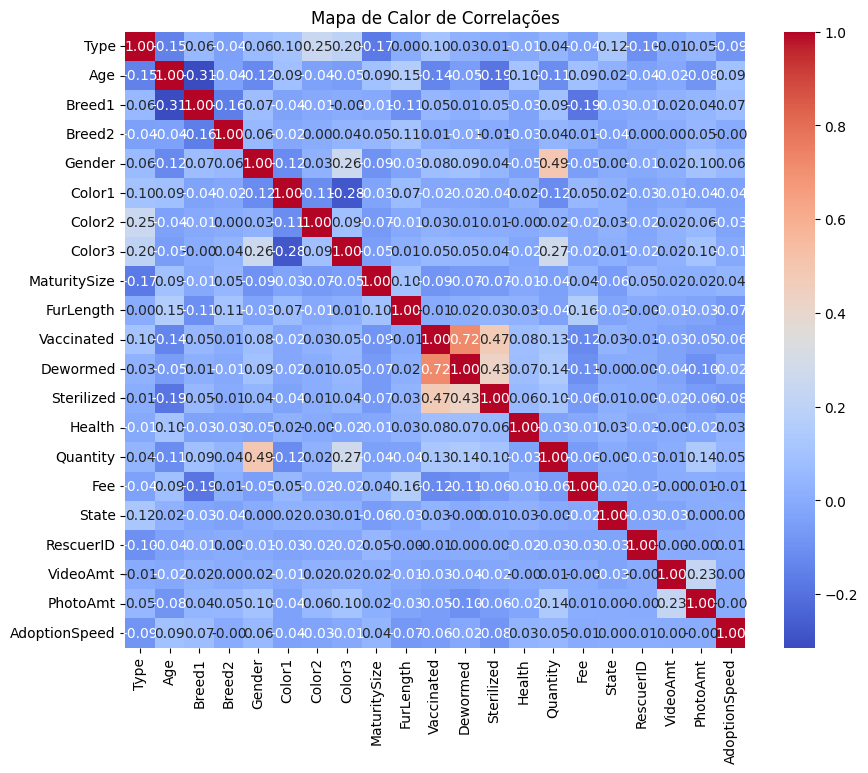

In [52]:
# Visualizar um mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlações')
plt.show()

### KMeans

In [53]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Suponha que 'df' seja o seu DataFrame com os dados
# Remover a coluna alvo (se houver) para clustering
df_clustering = df.drop('AdoptionSpeed', axis=1)

# Padronizar os dados
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

In [54]:
# Inicializar o modelo K-means
kmeans = KMeans(n_clusters=5, random_state=42)  # Ajuste o número de clusters conforme necessário

# Ajustar o modelo aos dados
kmeans.fit(df_clustering_scaled)

# Obter os rótulos dos clusters
labels = kmeans.labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels

# Exibir os primeiros registros do DataFrame com os clusters
print(df.head())

   Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize   
0     2    3     299       0       1       1       7       0             1  \
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   
3     1    4     307       0       2       1       2       0             2   
4     1    1     307       0       1       1       0       0             2   

   FurLength  ...  Sterilized  Health  Quantity  Fee  State  RescuerID   
0          1  ...           2       1         1  100  41326       2932  \
1          2  ...           3       1         1    0  41401       1113   
2          2  ...           2       1         1    0  41326       5485   
3          1  ...           2       1         1  150  41401       3232   
4          1  ...           2       1         1    0  41326       3297   

   VideoAmt  PhotoAmt  AdoptionSpeed  Cluster  
0         0       1.0              0  

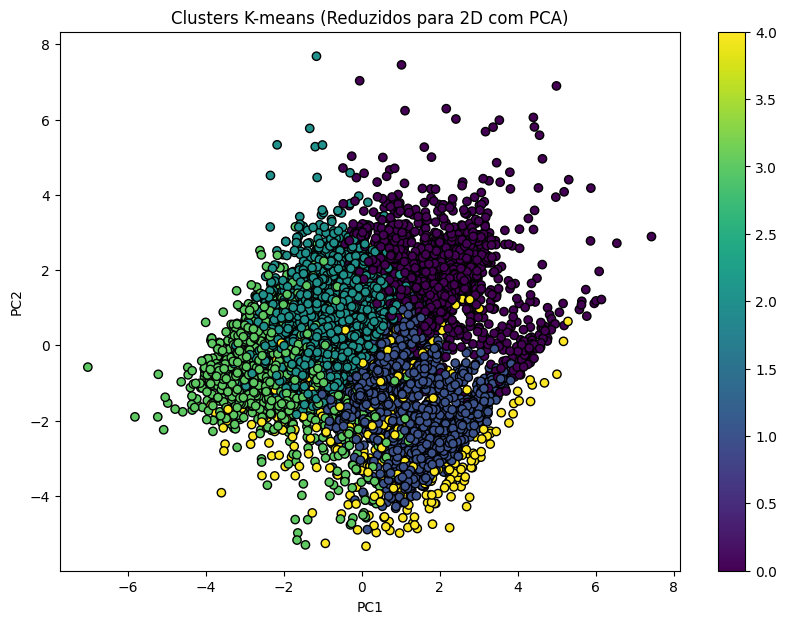

In [55]:
# Usar PCA para reduzir a dimensionalidade para 2D para visualização
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_clustering_scaled)

# Criar um DataFrame com os componentes principais
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

# Plotar os clusters
plt.figure(figsize=(10, 7))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters K-means (Reduzidos para 2D com PCA)')
plt.colorbar()
plt.show()


## Colunas com maiores correlações com o TARGET

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [57]:
# Calcule as correlações entre as colunas e a variável alvo
correlacoes = df.corr()['AdoptionSpeed'].abs().sort_values(ascending=False)

In [58]:
correlacoes

AdoptionSpeed    1.000000
Age              0.092891
Type             0.085406
Sterilized       0.078573
FurLength        0.073389
Breed1           0.071457
Vaccinated       0.059920
Gender           0.058508
Quantity         0.046280
MaturitySize     0.039174
Color1           0.038220
Health           0.030743
Color2           0.028916
Cluster          0.017432
Dewormed         0.015696
Color3           0.008506
RescuerID        0.006241
Fee              0.005748
State            0.004830
VideoAmt         0.003005
Breed2           0.001286
PhotoAmt         0.000191
Name: AdoptionSpeed, dtype: float64

In [59]:
# Ordene as correlações da variável alvo em ordem decrescente
correlacoes_alvo = matriz_correlacao['AdoptionSpeed'].abs().sort_values(ascending=False)

# Selecionar as colunas com uma correlação acima de um certo limiar (threshold)
threshold = 0.001  # Este valor pode ser ajustado conforme necessário
colunas_selecionadas = correlacoes_alvo[correlacoes_alvo > threshold].index.tolist()

# Remova a variável alvo da lista de colunas selecionadas
colunas_selecionadas.remove('AdoptionSpeed')

# Criar um novo DataFrame com apenas as colunas selecionadas
dados_selecionados = df[colunas_selecionadas + ['AdoptionSpeed']]

print(dados_selecionados.columns)

Index(['Age', 'Type', 'Sterilized', 'FurLength', 'Breed1', 'Vaccinated',
       'Gender', 'Quantity', 'MaturitySize', 'Color1', 'Health', 'Color2',
       'Dewormed', 'Color3', 'RescuerID', 'Fee', 'State', 'VideoAmt', 'Breed2',
       'AdoptionSpeed'],
      dtype='object')


### Random Forest

In [60]:
# Dividir o DataFrame em X (características) e y (alvo)
X = dados_selecionados.drop('AdoptionSpeed', axis=1)  # Remove a coluna alvo para obter o conjunto de características
y = dados_selecionados['AdoptionSpeed']  # Obtém apenas a coluna alv

# Dividir os dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o classificador Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o classificador
clf.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
previsoes = clf.predict(X_teste)

# Calcular a precisão
precisao = accuracy_score(y_teste, previsoes)

Precisão: 0.6538846282094032


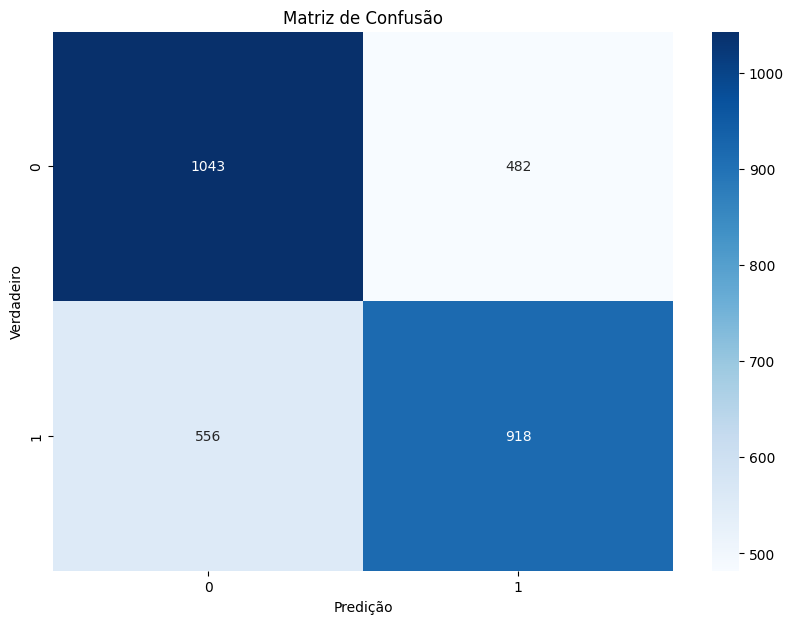

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      1525
           1       0.66      0.62      0.64      1474

    accuracy                           0.65      2999
   macro avg       0.65      0.65      0.65      2999
weighted avg       0.65      0.65      0.65      2999



In [61]:
# Calcular a precisão
precisao = accuracy_score(y_teste, previsoes)
print("Precisão:", precisao)

# Calcular a matriz de confusão
matriz_confusao = confusion_matrix(y_teste, previsoes)

# Plotar a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Exibir o relatório de classificação
relatorio_classificacao = classification_report(y_teste, previsoes)
print("Relatório de Classificação:\n", relatorio_classificacao)

(array([7537.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7456.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

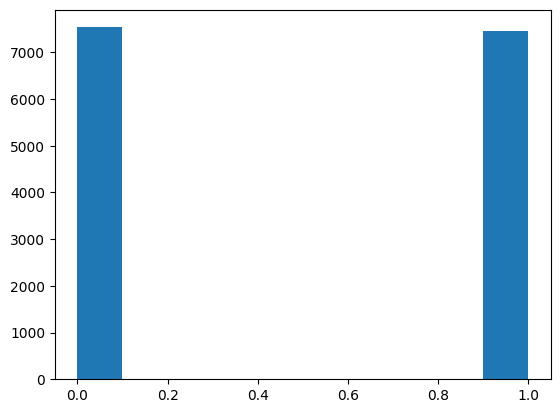

In [62]:
plt.hist(df['AdoptionSpeed'])